In [1]:
import sys
!{sys.executable} -m pip install matplotlib pandas xlrd seaborn tqdm scikit-learn tensorflow

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tqdm
import numpy as np

from sklearn.cluster import KMeans

Чтение данных из Excel

In [ ]:
sales = pd.read_excel('ДанныеДекабря_2017.xlsx', 'Продажи')
sales = sales.set_index('Material')

ap = pd.read_excel('ДанныеДекабря_2017.xlsx', 'Магазины')
ap = ap.set_index('Material')

stock = pd.read_excel('ДанныеДекабря_2017.xlsx', 'Остатки')
stock = stock.set_index('Material')

price = pd.read_excel('ДанныеДекабря_2017.xlsx', 'Цены')
price = price.set_index('Material')

hierarchy = pd.read_excel('hierarchy.xlsx')

sell = pd.read_excel('Акции.xlsx')

In [ ]:
sales.head()

Создание DataFrame для анализа зависимостей между переменными по артикулам

In [ ]:
full_train_data = pd.DataFrame()

for x in tqdm.tqdm(sales.index[:]):
    material = x

    df = pd.concat([sales.loc[material].rename('sales'),\
               sales.loc[material].shift(-1).rename('sales_1'),\
               sales.loc[material].shift(-2).rename('sales_2'),\
               sales.loc[material].shift(-12).rename('sales_12'),\
               sales.loc[material].subtract(sales.loc[material].shift(-1)).rename('sales_diff_1'),\
               sales.loc[material].subtract(sales.loc[material].shift(-2)).rename('sales_diff_2'),\
               sales.loc[material].subtract(sales.loc[material].shift(-12)).rename('sales_diff_12'),\
               stock.loc[material].shift(-1).rename('stock_1'),\
               stock.loc[material].shift(-2).rename('stock_2'),\
               stock.loc[material].subtract(stock.loc[material].shift(-1)).rename('stock_diff_1'),\
               stock.loc[material].subtract(stock.loc[material].shift(-2)).rename('stock_diff_2'),\
               price.loc[material].shift(-1).rename('price_1'),\
               price.loc[material].shift(-1).rename('price_2'),\
               price.loc[material].subtract(price.loc[material].shift(-1)).rename('price_diff_1'),\
               price.loc[material].subtract(price.loc[material].shift(-1)).rename('price_diff_2'),\
               ap.loc[material].shift(-1).rename('ap_1'),\
               ap.loc[material].shift(-1).rename('ap_2'),\
               ap.loc[material].subtract(ap.loc[material].shift(-1)).rename('ap_diff_1'),\
               ap.loc[material].subtract(ap.loc[material].shift(-1)).rename('ap_diff_2')],\
              axis=1)

    df = df.dropna()

    full_train_data = full_train_data.append(df)
    
full_train_data.loc[:,'month'] = df.index.month

In [6]:
corr_df = pd.DataFrame()

for x in tqdm.tqdm(sales.index[:]):
    test_material = x

    df = pd.concat([sales.loc[test_material].rename('sales'),\
               sales.loc[test_material].shift(-1).rename('sales_1'),\
               sales.loc[test_material].shift(-2).rename('sales_2'),\
               sales.loc[test_material].shift(-12).rename('sales_12'),\
               sales.loc[test_material].subtract(sales.loc[test_material].shift(-1)).rename('sales_diff_1'),\
               sales.loc[test_material].subtract(sales.loc[test_material].shift(-2)).rename('sales_diff_2'),\
               sales.loc[test_material].subtract(sales.loc[test_material].shift(-12)).rename('sales_diff_12'),\
               stock.loc[test_material].shift(-1).rename('stock_1'),\
               stock.loc[test_material].shift(-2).rename('stock_2'),\
               stock.loc[test_material].subtract(stock.loc[test_material].shift(-1)).rename('stock_diff_1'),\
               stock.loc[test_material].subtract(stock.loc[test_material].shift(-2)).rename('stock_diff_2'),\
               price.loc[test_material].shift(-1).rename('price_1'),\
               price.loc[test_material].shift(-1).rename('price_2'),\
               price.loc[test_material].subtract(price.loc[test_material].shift(-1)).rename('price_diff_1'),\
               price.loc[test_material].subtract(price.loc[test_material].shift(-1)).rename('price_diff_2'),\
               ap.loc[test_material].shift(-1).rename('ap_1'),\
               ap.loc[test_material].shift(-1).rename('ap_2'),\
               ap.loc[test_material].subtract(ap.loc[test_material].shift(-1)).rename('ap_diff_1'),\
               ap.loc[test_material].subtract(ap.loc[test_material].shift(-1)).rename('ap_diff_2')],\
              axis=1)

    df.loc[:,'month'] = df.index.month

    df = df.dropna()

    corr_df = corr_df.append(df.corr().abs().sales.rename(test_material))

100%|██████████| 7032/7032 [02:53<00:00, 35.89it/s]


Убираем строки у которых недостаточная статистика по продажам, их оценивать отдельно

In [7]:
corr_df = corr_df.fillna(0)

Выделение групп артикулов для ращного прогнозирования на основе коррелляции

In [8]:
#Cluster the data
kmeans = KMeans(n_clusters=5, random_state=0).fit(corr_df)
labels = kmeans.labels_

#Glue back to originaal data
corr_df['clusters'] = labels

# Создание нормализованной DF
corr_overal_df = corr_df.groupby('clusters').mean()

corr_overal_norm_df = (corr_overal_df-corr_overal_df.min())/(corr_overal_df.max()-corr_overal_df.min())

Отображение кластеров и кластеров

In [9]:
corr_overal_norm_df.style.background_gradient(cmap='viridis')

,ap_1,ap_2,ap_diff_1,ap_diff_2,month,price_1,price_2,price_diff_1,price_diff_2,sales,sales_1,sales_12,sales_2,sales_diff_1,sales_diff_12,sales_diff_2,stock_1,stock_2,stock_diff_1,stock_diff_2
clusters,,,,,,,,,,,,,,,,,,,,
0,0.38665,0.38665,1,1,0.881084,0.30185,0.30185,1,1,1,0.360191,0.812177,0.274081,0.750959,1,1,0.377518,0.359412,0.591007,0.791681
1,0.952442,0.952442,0.393384,0.393384,0.784214,0.925197,0.925197,0.578856,0.578856,1,0.790335,0.941499,1,0.361939,0.684656,0.494518,0.919746,1,0.295424,0.456149
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.733283,0.733283,0.654286,0.654286,0.861264,0.585946,0.585946,0.793977,0.793977,1,0.573715,0.743596,0.62203,0.579164,0.914694,0.781775,0.704104,0.748895,0.405403,0.607441
4,1,1,0.871891,0.871891,1,1,1,0.515931,0.515931,1,1,1,0.886498,1,0.514497,0.543848,1,0.949668,1,1


Вычисление колонок у кластера для использования для прогнозирования

In [10]:
# Будем отсекать по средней корелляции, за исключением артикулов, у которых нет данных
threshold = corr_overal_df[corr_overal_df.sales > 0.1].mean()
# Инициализация копии DF
corr_thresh_df = corr_overal_df.copy()
# Прогон сравнения по всем колонкам
for col in corr_overal_df.columns:
    corr_thresh_df[col] = (corr_overal_df[col] >= threshold[col]).astype(int)
    
corr_thresh_df.style.background_gradient(cmap='viridis')

,ap_1,ap_2,ap_diff_1,ap_diff_2,month,price_1,price_2,price_diff_1,price_diff_2,sales,sales_1,sales_12,sales_2,sales_diff_1,sales_diff_12,sales_diff_2,stock_1,stock_2,stock_diff_1,stock_diff_2
clusters,,,,,,,,,,,,,,,,,,,,
0,0,0,1,1,0,0,0,1,1,1,0,0,0,1,1,1,0,0,1,1
1,1,1,0,0,0,1,1,0,0,1,1,1,1,0,0,0,1,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,1,0,0,0,0
4,1,1,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1


In [44]:
def get_cluster_id(material_id):
    return corr_df.loc[material_id, 'clusters']

Создаем DF для всех материалов для обучения нейронки

In [52]:
full_train_data = pd.DataFrame()

for x in tqdm.tqdm(sales.index[:]):
    material = x

    df = pd.concat([sales.loc[material].rename('sales'),\
               sales.loc[material].shift(-1).rename('sales_1'),\
               sales.loc[material].shift(-2).rename('sales_2'),\
               sales.loc[material].shift(-12).rename('sales_12'),\
               sales.loc[material].subtract(sales.loc[material].shift(-1)).rename('sales_diff_1'),\
               sales.loc[material].subtract(sales.loc[material].shift(-2)).rename('sales_diff_2'),\
               sales.loc[material].subtract(sales.loc[material].shift(-12)).rename('sales_diff_12'),\
               stock.loc[material].shift(-1).rename('stock_1'),\
               stock.loc[material].shift(-2).rename('stock_2'),\
               stock.loc[material].subtract(stock.loc[material].shift(-1)).rename('stock_diff_1'),\
               stock.loc[material].subtract(stock.loc[material].shift(-2)).rename('stock_diff_2'),\
               price.loc[material].shift(-1).rename('price_1'),\
               price.loc[material].shift(-1).rename('price_2'),\
               price.loc[material].subtract(price.loc[material].shift(-1)).rename('price_diff_1'),\
               price.loc[material].subtract(price.loc[material].shift(-1)).rename('price_diff_2'),\
               ap.loc[material].shift(-1).rename('ap_1'),\
               ap.loc[material].shift(-1).rename('ap_2'),\
               ap.loc[material].subtract(ap.loc[material].shift(-1)).rename('ap_diff_1'),\
               ap.loc[material].subtract(ap.loc[material].shift(-1)).rename('ap_diff_2')],\
              axis=1)

    df.loc[:,'cluster'] = get_cluster_id(material)
    df.loc[:,'month'] = df.index.month

    df = df.dropna()

    full_train_data = full_train_data.append(df)

 55%|█████▌    | 3885/7032 [06:18<21:51,  2.40it/s]

KeyboardInterrupt: 

Создаем тренировочные данные

In [ ]:
full_train_data.description()

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X = full_train_data[[col for col in df.columns if col != 'sales']]

Y = full_train_data.sales.to_frame()

scaler = MinMaxScaler()

print(scaler.fit(X))
print(scaler.fit(Y))

xscale=scaler.transform(X)
yscale=scaler.transform(Y)

X_train, X_test, y_train, y_test = train_test_split(xscale, yscale)

MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler(copy=True, feature_range=(0, 1))


/srv/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [38]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor

model = Sequential()
model.add(Dense(12, input_dim=9, kernel_initializer='normal', activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 12)                120       
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 9         
Total params: 233
Trainable params: 233
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

In [40]:
history = model.fit(X_train, y_train, epochs=150, batch_size=50,  verbose=1, validation_split=0.2)

Train on 20 samples, validate on 6 samples
Epoch 1/250
20/20 [==============================] - 0s 14ms/sample - loss: 870.5330 - mean_squared_error: 870.5330 - mean_absolute_error: 17.4451 - val_loss: 1245.9261 - val_mean_squared_error: 1245.9261 - val_mean_absolute_error: 23.6235
Epoch 2/250
20/20 [==============================] - 0s 319us/sample - loss: 779.0914 - mean_squared_error: 779.0914 - mean_absolute_error: 16.4477 - val_loss: 1108.7198 - val_mean_squared_error: 1108.7198 - val_mean_absolute_error: 22.1770
Epoch 3/250
20/20 [==============================] - 0s 309us/sample - loss: 692.8600 - mean_squared_error: 692.8600 - mean_absolute_error: 15.4192 - val_loss: 980.4623 - val_mean_squared_error: 980.4623 - val_mean_absolute_error: 20.7199
Epoch 4/250
20/20 [==============================] - 0s 2ms/sample - loss: 612.2440 - mean_squared_error: 612.2440 - mean_absolute_error: 14.3810 - val_loss: 862.7895 - val_mean_squared_error: 862.7895 - val_mean_absolute_error: 19.2798


Epoch 36/250
20/20 [==============================] - 0s 397us/sample - loss: 5.5920 - mean_squared_error: 5.5920 - mean_absolute_error: 1.2830 - val_loss: 7.3650 - val_mean_squared_error: 7.3650 - val_mean_absolute_error: 1.6406
Epoch 37/250
20/20 [==============================] - 0s 347us/sample - loss: 4.6534 - mean_squared_error: 4.6534 - mean_absolute_error: 1.1802 - val_loss: 6.0037 - val_mean_squared_error: 6.0037 - val_mean_absolute_error: 1.4913
Epoch 38/250
20/20 [==============================] - 0s 412us/sample - loss: 3.8102 - mean_squared_error: 3.8102 - mean_absolute_error: 1.0782 - val_loss: 4.7999 - val_mean_squared_error: 4.7999 - val_mean_absolute_error: 1.3444
Epoch 39/250
20/20 [==============================] - 0s 3ms/sample - loss: 3.0652 - mean_squared_error: 3.0652 - mean_absolute_error: 0.9779 - val_loss: 3.7537 - val_mean_squared_error: 3.7537 - val_mean_absolute_error: 1.2007
Epoch 40/250
20/20 [==============================] - 0s 336us/sample - loss: 2.41

Epoch 72/250
20/20 [==============================] - 0s 365us/sample - loss: 0.1984 - mean_squared_error: 0.1984 - mean_absolute_error: 0.3599 - val_loss: 0.1110 - val_mean_squared_error: 0.1110 - val_mean_absolute_error: 0.2889
Epoch 73/250
20/20 [==============================] - 0s 375us/sample - loss: 0.1872 - mean_squared_error: 0.1872 - mean_absolute_error: 0.3488 - val_loss: 0.0933 - val_mean_squared_error: 0.0933 - val_mean_absolute_error: 0.2700
Epoch 74/250
20/20 [==============================] - 0s 348us/sample - loss: 0.1753 - mean_squared_error: 0.1753 - mean_absolute_error: 0.3358 - val_loss: 0.0762 - val_mean_squared_error: 0.0762 - val_mean_absolute_error: 0.2490
Epoch 75/250
20/20 [==============================] - 0s 317us/sample - loss: 0.1638 - mean_squared_error: 0.1638 - mean_absolute_error: 0.3213 - val_loss: 0.0609 - val_mean_squared_error: 0.0609 - val_mean_absolute_error: 0.2263
Epoch 76/250
20/20 [==============================] - 0s 339us/sample - loss: 0.

Epoch 108/250
20/20 [==============================] - 0s 371us/sample - loss: 0.1305 - mean_squared_error: 0.1305 - mean_absolute_error: 0.2528 - val_loss: 0.0312 - val_mean_squared_error: 0.0312 - val_mean_absolute_error: 0.1637
Epoch 109/250
20/20 [==============================] - 0s 3ms/sample - loss: 0.1302 - mean_squared_error: 0.1302 - mean_absolute_error: 0.2525 - val_loss: 0.0311 - val_mean_squared_error: 0.0311 - val_mean_absolute_error: 0.1644
Epoch 110/250
20/20 [==============================] - 0s 378us/sample - loss: 0.1300 - mean_squared_error: 0.1300 - mean_absolute_error: 0.2523 - val_loss: 0.0310 - val_mean_squared_error: 0.0310 - val_mean_absolute_error: 0.1651
Epoch 111/250
20/20 [==============================] - 0s 312us/sample - loss: 0.1297 - mean_squared_error: 0.1297 - mean_absolute_error: 0.2520 - val_loss: 0.0310 - val_mean_squared_error: 0.0310 - val_mean_absolute_error: 0.1658
Epoch 112/250
20/20 [==============================] - 0s 333us/sample - loss:

Epoch 144/250
20/20 [==============================] - 0s 290us/sample - loss: 0.1281 - mean_squared_error: 0.1281 - mean_absolute_error: 0.2487 - val_loss: 0.0307 - val_mean_squared_error: 0.0307 - val_mean_absolute_error: 0.1654
Epoch 145/250
20/20 [==============================] - 0s 3ms/sample - loss: 0.1281 - mean_squared_error: 0.1281 - mean_absolute_error: 0.2486 - val_loss: 0.0307 - val_mean_squared_error: 0.0307 - val_mean_absolute_error: 0.1655
Epoch 146/250
20/20 [==============================] - 0s 396us/sample - loss: 0.1280 - mean_squared_error: 0.1280 - mean_absolute_error: 0.2485 - val_loss: 0.0307 - val_mean_squared_error: 0.0307 - val_mean_absolute_error: 0.1656
Epoch 147/250
20/20 [==============================] - 0s 363us/sample - loss: 0.1280 - mean_squared_error: 0.1280 - mean_absolute_error: 0.2484 - val_loss: 0.0308 - val_mean_squared_error: 0.0308 - val_mean_absolute_error: 0.1657
Epoch 148/250
20/20 [==============================] - 0s 350us/sample - loss:

Epoch 180/250
20/20 [==============================] - 0s 288us/sample - loss: 0.1266 - mean_squared_error: 0.1266 - mean_absolute_error: 0.2452 - val_loss: 0.0301 - val_mean_squared_error: 0.0301 - val_mean_absolute_error: 0.1637
Epoch 181/250
20/20 [==============================] - 0s 327us/sample - loss: 0.1265 - mean_squared_error: 0.1265 - mean_absolute_error: 0.2451 - val_loss: 0.0301 - val_mean_squared_error: 0.0301 - val_mean_absolute_error: 0.1637
Epoch 182/250
20/20 [==============================] - 0s 3ms/sample - loss: 0.1265 - mean_squared_error: 0.1265 - mean_absolute_error: 0.2450 - val_loss: 0.0301 - val_mean_squared_error: 0.0301 - val_mean_absolute_error: 0.1636
Epoch 183/250
20/20 [==============================] - 0s 459us/sample - loss: 0.1264 - mean_squared_error: 0.1264 - mean_absolute_error: 0.2449 - val_loss: 0.0300 - val_mean_squared_error: 0.0300 - val_mean_absolute_error: 0.1636
Epoch 184/250
20/20 [==============================] - 0s 362us/sample - loss:

Epoch 216/250
20/20 [==============================] - 0s 387us/sample - loss: 0.1249 - mean_squared_error: 0.1249 - mean_absolute_error: 0.2414 - val_loss: 0.0293 - val_mean_squared_error: 0.0293 - val_mean_absolute_error: 0.1614
Epoch 217/250
20/20 [==============================] - 0s 411us/sample - loss: 0.1248 - mean_squared_error: 0.1248 - mean_absolute_error: 0.2413 - val_loss: 0.0293 - val_mean_squared_error: 0.0293 - val_mean_absolute_error: 0.1613
Epoch 218/250
20/20 [==============================] - 0s 323us/sample - loss: 0.1248 - mean_squared_error: 0.1248 - mean_absolute_error: 0.2412 - val_loss: 0.0293 - val_mean_squared_error: 0.0293 - val_mean_absolute_error: 0.1613
Epoch 219/250
20/20 [==============================] - 0s 363us/sample - loss: 0.1247 - mean_squared_error: 0.1247 - mean_absolute_error: 0.2411 - val_loss: 0.0293 - val_mean_squared_error: 0.0293 - val_mean_absolute_error: 0.1612
Epoch 220/250
20/20 [==============================] - 0s 369us/sample - los

dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error'])


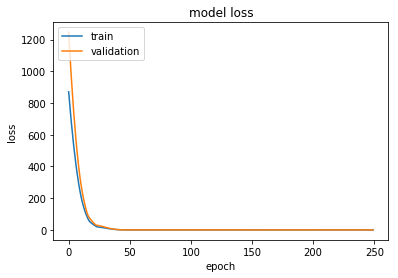

In [41]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [42]:
model.evaluate(X_test, y_test, batch_size=50)

9/9 [==============================] - 0s 163us/sample - loss: 0.0329 - mean_squared_error: 0.0329 - mean_absolute_error: 0.1685


[0.032930098474025726, 0.0329301, 0.16849458]